# Import Libary

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import talib

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from math import sqrt
from matplotlib import pyplot
from numpy import array
import numpy as np
from keras.layers import LSTM , CuDNNLSTM
import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *  
sns.set()



C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


In [137]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Load Data

         Date       Open       High        Low      Close  Adj Close  \
0  2007-01-02  55.521000  57.466499  55.371399  56.867901  38.202568   
1  2007-01-03  57.167198  58.813400  57.017502  57.840599  38.856010   
2  2007-01-04  57.765800  57.990299  57.092400  57.765800  38.805763   
3  2007-01-05  57.616100  57.691002  56.792999  56.792999  38.152256   
4  2007-01-08  56.119598  56.119598  55.146900  55.296501  37.146938   

       Volume  
0  27682832.0  
1  38041509.0  
2  27239137.0  
3  24146636.0  
4  30340993.0  


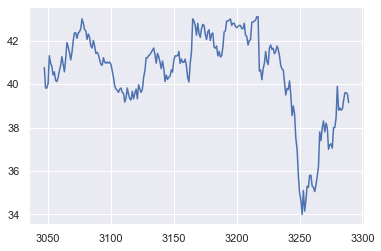

In [138]:
df = pd.read_csv('input/2882.TW.csv')
print(df.head())
series = df.dropna(axis=0,how='any')
series = series['Close']
plt.plot(series[-243:])

# Caculate technical indicators by talib

In [139]:
from talib import abstract
df = pd.read_csv('input/2882.TW.csv')
print(df[df.isnull().any(axis=1)])
df = df.dropna()
df = df.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adj Close",
                        "Volume": "volume"})
#df = df.drop(['date', 'adj Close'], axis=1)

            Date  Open  High  Low  Close  Adj Close  Volume
2247  2016-01-30   NaN   NaN  NaN    NaN        NaN     NaN
2327  2016-06-04   NaN   NaN  NaN    NaN        NaN     NaN
2396  2016-09-10   NaN   NaN  NaN    NaN        NaN     NaN
2502  2017-02-18   NaN   NaN  NaN    NaN        NaN     NaN
2571  2017-06-03   NaN   NaN  NaN    NaN        NaN     NaN


In [140]:
ta_list = talib.get_functions()

for x in ta_list:
    try:
        output = eval('abstract.'+x+'(df)')
        output.name = x.lower() if type(output) == pd.core.series.Series else None
        df = pd.merge(df, pd.DataFrame(output), left_on = df.index, right_on = output.index)
        df = df.set_index('key_0')
    except:
        print(x)

MAVP


In [141]:
df = df.drop(['date', 'adj Close'], axis=1)
df.head()

,open,high,low,close,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
0,55.521000,57.466499,55.371399,56.867901,27682832.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186412e+07,NaN,27682832.0
1,57.167198,58.813400,57.017502,57.840599,38041509.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.945499,8.693027e+06,NaN,65724341.0
2,57.765800,57.990299,57.092400,57.765800,27239137.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.897899,2.231112e+07,NaN,38485204.0
3,57.616100,57.691002,56.792999,56.792999,24146636.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.972801,-1.835512e+06,NaN,14338568.0
4,56.119598,56.119598,55.146900,55.296501,30340993.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.918391,NaN,0.843442,NaN,NaN,1.646099,-2.284361e+07,NaN,-16002425.0


In [142]:
null_column_list_number = df.isnull().sum().values
null_column_name_list = df.isnull().sum().index
null_column_list_number

array([   0,    0,    0,    0,    0,   32,   63,   32,   32,   63,   63,
          0,    0,    0,   29,    0,   29,    0,   29,   29,    0,    0,
          0,    0,   29, 3285, 3285,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   27,   40,   25,   14,
         14,   14,    0,   13,   14,   14,   33,   33,   33,   33,   33,
         33,   33,   33,   33,   14,   14,   13,   10,   14,   13,   25,
         10,   10,   10,   10,   14,    8,    8,    6,    6,   20,   20,
         88,   28,   13,    4,    4,    4,   58,   29,   63,   30,   29,
         32,   32,   13,   13,    1,    1,   29,   24,   87,   29,   29,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [143]:
for i in range(len(null_column_list_number)):
    if null_column_list_number[i] > 0:
        index = i
        print(null_column_name_list[i], " ", null_column_list_number[i])

ht_dcperiod   32
ht_dcphase   63
inphase   32
quadrature   32
sine   63
leadsine   63
max_x   29
min_x   29
min_y   29
max_y   29
sum   29
acos   3285
asin   3285
adx   27
adxr   40
apo   25
aroondown   14
aroonup   14
aroonosc   14
cci   13
cmo   14
dx   14
macd_x   33
macdsignal_x   33
macdhist_x   33
macd_y   33
macdsignal_y   33
macdhist_y   33
macd   33
macdsignal   33
macdhist   33
mfi   14
minus_di   14
minus_dm   13
mom   10
plus_di   14
plus_dm   13
ppo   25
roc   10
rocp   10
rocr   10
rocr100   10
rsi   14
slowk   8
slowd   8
fastk_x   6
fastd_x   6
fastk_y   20
fastd_y   20
trix   88
ultosc   28
willr   13
upperband   4
middleband   4
lowerband   4
dema   58
ema   29
ht_trendline   63
kama   30
ma   29
mama   32
fama   32
midpoint   13
midprice   13
sar   1
sarext   1
sma   29
t3   24
tema   87
trima   29
wma   29
beta   5
correl   29
linearreg   13
linearreg_angle   13
linearreg_intercept   13
linearreg_slope   13
stddev   4
tsf   13
var   4
atr   14
natr   14
trange   1
a

In [144]:
df

,open,high,low,close,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
0,55.521000,57.466499,55.371399,56.867901,27682832.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186412e+07,NaN,2.768283e+07
1,57.167198,58.813400,57.017502,57.840599,38041509.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.945499,8.693027e+06,NaN,6.572434e+07
2,57.765800,57.990299,57.092400,57.765800,27239137.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.897899,2.231112e+07,NaN,3.848520e+07
3,57.616100,57.691002,56.792999,56.792999,24146636.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.972801,-1.835512e+06,NaN,1.433857e+07
4,56.119598,56.119598,55.146900,55.296501,30340993.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.918391,NaN,0.843442,NaN,NaN,1.646099,-2.284361e+07,NaN,-1.600242e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,39.250000,39.500000,39.049999,39.250000,11447894.0,19.710384,154.649448,1.814150,0.241700,0.428155,...,0.170220,0.169116,39.523077,0.028600,0.759094,1.933998,0.650002,1.408137e+10,5.124562e+06,9.669979e+10
3286,39.500000,39.900002,39.500000,39.599998,14051677.0,19.028121,154.264077,1.361271,-1.829408,0.434224,...,0.200769,0.304302,39.866483,0.092600,0.751302,1.897227,0.650002,1.407434e+10,1.143105e+06,9.671385e+10
3287,39.400002,39.700001,39.299999,39.599998,12594120.0,18.344453,168.946908,0.366481,-1.494815,0.191719,...,0.191319,0.347275,39.981317,0.120600,0.726209,1.833861,0.400002,1.408064e+10,1.413969e+06,9.671385e+10


In [145]:
df = df.drop(['acos', 'asin'], axis=1)

In [146]:
df = df.dropna()

In [147]:
print(len(df.columns))

177


In [149]:
cols = ['close']  + [col for col in df if col != 'close']
df = df[cols]
df

,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
88,53.126598,52.827301,53.500702,52.303501,18869070.0,14.738178,249.719363,-0.571632,0.131244,-0.938006,...,0.034044,0.226959,53.376572,0.051510,1.049726,1.975896,1.197201,-1.924823e+08,-1.154568e+07,9.867138e+07
89,53.051800,53.051800,53.500702,52.752399,12259082.0,14.773288,268.263490,-0.416688,0.209047,-0.999541,...,-0.066437,0.214795,52.831414,0.046137,1.028196,1.938099,0.748303,-1.949315e+08,-1.019757e+07,8.641230e+07
90,54.099300,53.500702,54.174099,53.425900,26329028.0,14.770787,290.092182,-0.353590,0.454140,-0.939141,...,-0.088146,0.488140,52.818248,0.238280,1.034918,1.912997,1.122299,-1.738668e+08,-2.016620e+06,1.127413e+08
91,53.949699,54.099300,54.323799,53.799999,12844439.0,14.747083,27.149310,-0.041047,0.260862,0.456311,...,-0.037001,0.568673,53.153735,0.323389,0.998409,1.850630,0.523800,-1.793695e+08,-2.373835e+05,9.989688e+07
92,52.902100,53.575500,53.575500,52.528000,17892139.0,14.728134,64.599030,-0.206071,0.111983,0.903328,...,-0.012827,0.496333,53.212109,0.246346,1.028644,1.944430,1.421699,-1.844818e+08,-1.114569e+06,8.200474e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,39.250000,39.250000,39.500000,39.049999,11447894.0,19.710384,154.649448,1.814150,0.241700,0.428155,...,0.170220,0.169116,39.523077,0.028600,0.759094,1.933998,0.650002,1.408137e+10,5.124562e+06,9.669979e+10
3286,39.599998,39.500000,39.900002,39.500000,14051677.0,19.028121,154.264077,1.361271,-1.829408,0.434224,...,0.200769,0.304302,39.866483,0.092600,0.751302,1.897227,0.650002,1.407434e+10,1.143105e+06,9.671385e+10
3287,39.599998,39.400002,39.700001,39.299999,12594120.0,18.344453,168.946908,0.366481,-1.494815,0.191719,...,0.191319,0.347275,39.981317,0.120600,0.726209,1.833861,0.400002,1.408064e+10,1.413969e+06,9.671385e+10


# Find important features 

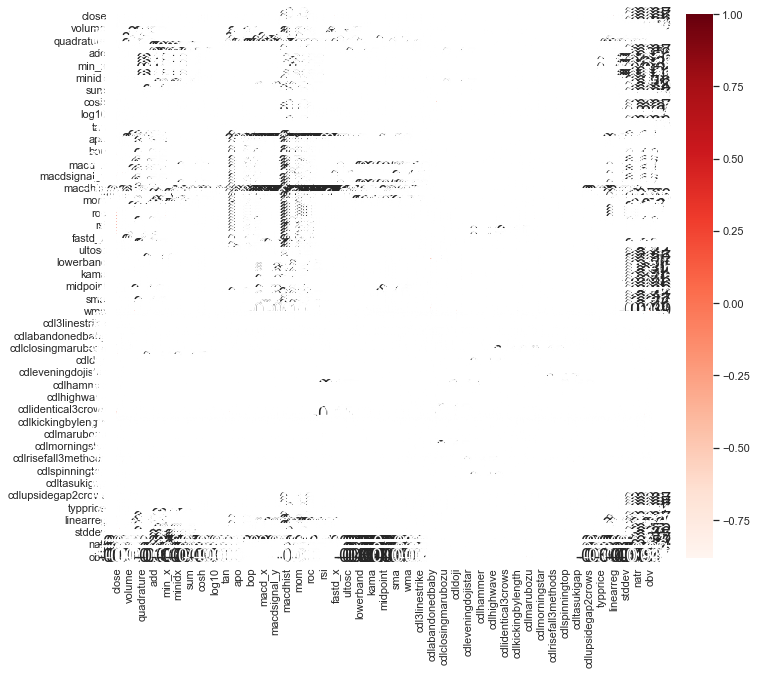

In [175]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [177]:
#Correlation with output variable
cor_target = abs(cor["close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)



close                  1.000000
open                   0.997823
high                   0.998970
low                    0.998918
add                    0.999345
max_x                  0.953812
min_x                  0.961694
min_y                  0.961694
max_y                  0.953812
mult                   0.989529
sum                    0.967300
atan                   0.959453
ceil                   0.999509
floor                  0.999509
ln                     0.989617
log10                  0.989617
sqrt                   0.997407
upperband              0.991261
middleband             0.995588
lowerband              0.990971
dema                   0.988818
ema                    0.976114
ht_trendline           0.972785
kama                   0.972230
ma                     0.967300
mama                   0.993273
fama                   0.976715
midpoint               0.987300
midprice               0.987168
sar                    0.961837
sma                    0.967300
t3      

In [181]:
df = df[relevant_features.index]

# Config

In [183]:
# configure
n_lag = 30
n_seq = 7
pred_steps = n_seq
n_test = 192
n_epochs =1500
n_batch = 32
n_neurons = 32
features = len(relevant_features)

In [185]:
seq2seq_raw_values = df.values
seq2seq_raw_values = seq2seq_raw_values[:].reshape(len(seq2seq_raw_values),features)
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
train, test = supervised_values[:-243*1], supervised_values[-243*1:]

print('train',train.shape)
print('test',test.shape)

train (2918, 1554)
test (243, 1554)


In [186]:
encoder_input_data , decoder_target_data = train[: ,:(n_lag+n_seq-1)*features] , train[:,n_lag*features:]
decoder_target_data = decoder_target_data[: , ::features]
encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0],(n_lag+n_seq-1),features))
decoder_target_data = decoder_target_data.reshape((decoder_target_data.shape[0],decoder_target_data.shape[1],1))
print("encoder_input_data",encoder_input_data.shape,"decoder_target_data",decoder_target_data.shape)

encoder_input_data (2918, 36, 42) decoder_target_data (2918, 7, 1)


In [187]:
print('encoder_input_data[-1]', encoder_input_data[0][-1][0])
print('decoder_target_data[-1]', decoder_target_data[0])

encoder_input_data[-1] 0.6994780235757665
decoder_target_data[-1] [[0.57693506]
 [0.57693506]
 [0.56818505]
 [0.71406913]
 [0.71406913]
 [0.69947802]
 [0.78409268]]


In [202]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, features))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)
    x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':n_seq})(x)

model = Model(history_seq, pred_seq_train)
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, 42)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          2720      
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 32)          0   

In [203]:
batch_size = 32
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=700,
                    validation_split=0.2)

Train on 2334 samples, validate on 584 samples
Epoch 1/700
2334/2334 [==============================] - 2s 988us/step - loss: 0.3506 - val_loss: 0.1873
Epoch 2/700
2334/2334 [==============================] - 1s 366us/step - loss: 0.1963 - val_loss: 0.0801
Epoch 3/700
2334/2334 [==============================] - 1s 364us/step - loss: 0.1702 - val_loss: 0.0375
Epoch 4/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.1514 - val_loss: 0.0737
Epoch 5/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.1421 - val_loss: 0.0369
Epoch 6/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.1358 - val_loss: 0.0531
Epoch 7/700
2334/2334 [==============================] - 1s 388us/step - loss: 0.1264 - val_loss: 0.0311
Epoch 8/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.1241 - val_loss: 0.0397
Epoch 9/700
2334/2334 [==============================] - 1s 388us/step - loss: 0.1186 - val_loss: 0.0381
Epoch 10

Epoch 78/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0839 - val_loss: 0.0260
Epoch 79/700
2334/2334 [==============================] - 1s 381us/step - loss: 0.0871 - val_loss: 0.0379
Epoch 80/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0840 - val_loss: 0.0381
Epoch 81/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0842 - val_loss: 0.0283
Epoch 82/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0839 - val_loss: 0.0480
Epoch 83/700
2334/2334 [==============================] - 1s 383us/step - loss: 0.0826 - val_loss: 0.0320
Epoch 84/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0833 - val_loss: 0.0681
Epoch 85/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0833 - val_loss: 0.0195
Epoch 86/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0849 - val_loss: 0.0283
Epoch 87/700
2334/2334 [======================

Epoch 155/700
2334/2334 [==============================] - 1s 390us/step - loss: 0.0821 - val_loss: 0.0296
Epoch 156/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0817 - val_loss: 0.0309
Epoch 157/700
2334/2334 [==============================] - 1s 393us/step - loss: 0.0815 - val_loss: 0.0506
Epoch 158/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0806 - val_loss: 0.0473
Epoch 159/700
2334/2334 [==============================] - 1s 398us/step - loss: 0.0834 - val_loss: 0.0237
Epoch 160/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.0807 - val_loss: 0.0542
Epoch 161/700
2334/2334 [==============================] - 1s 392us/step - loss: 0.0826 - val_loss: 0.0331
Epoch 162/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0811 - val_loss: 0.0262
Epoch 163/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0818 - val_loss: 0.0430
Epoch 164/700
2334/2334 [============

2334/2334 [==============================] - 1s 386us/step - loss: 0.0813 - val_loss: 0.0288
Epoch 232/700
2334/2334 [==============================] - 1s 394us/step - loss: 0.0802 - val_loss: 0.0417
Epoch 233/700
2334/2334 [==============================] - 1s 398us/step - loss: 0.0800 - val_loss: 0.0350
Epoch 234/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0818 - val_loss: 0.0206
Epoch 235/700
2334/2334 [==============================] - 1s 393us/step - loss: 0.0820 - val_loss: 0.0221
Epoch 236/700
2334/2334 [==============================] - 1s 394us/step - loss: 0.0802 - val_loss: 0.0282
Epoch 237/700
2334/2334 [==============================] - 1s 397us/step - loss: 0.0823 - val_loss: 0.0239
Epoch 238/700
2334/2334 [==============================] - 1s 395us/step - loss: 0.0791 - val_loss: 0.0273
Epoch 239/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.0794 - val_loss: 0.0233
Epoch 240/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 385us/step - loss: 0.0789 - val_loss: 0.0267
Epoch 308/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0796 - val_loss: 0.0237
Epoch 309/700
2334/2334 [==============================] - 1s 392us/step - loss: 0.0803 - val_loss: 0.0283
Epoch 310/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0820 - val_loss: 0.0250
Epoch 311/700
2334/2334 [==============================] - 1s 388us/step - loss: 0.0802 - val_loss: 0.0391
Epoch 312/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0794 - val_loss: 0.0540
Epoch 313/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0798 - val_loss: 0.0229
Epoch 314/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0804 - val_loss: 0.0323
Epoch 315/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0805 - val_loss: 0.0339
Epoch 316/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 393us/step - loss: 0.0800 - val_loss: 0.0221
Epoch 384/700
2334/2334 [==============================] - 1s 398us/step - loss: 0.0794 - val_loss: 0.0318
Epoch 385/700
2334/2334 [==============================] - 1s 397us/step - loss: 0.0780 - val_loss: 0.0278
Epoch 386/700
2334/2334 [==============================] - 1s 388us/step - loss: 0.0808 - val_loss: 0.0352
Epoch 387/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.0796 - val_loss: 0.0456
Epoch 388/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0784 - val_loss: 0.0285
Epoch 389/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0802 - val_loss: 0.0440
Epoch 390/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0794 - val_loss: 0.0293
Epoch 391/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0815 - val_loss: 0.0263
Epoch 392/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 388us/step - loss: 0.0786 - val_loss: 0.0477
Epoch 460/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0777 - val_loss: 0.0707
Epoch 461/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0791 - val_loss: 0.0483
Epoch 462/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0788 - val_loss: 0.0208
Epoch 463/700
2334/2334 [==============================] - 1s 392us/step - loss: 0.0794 - val_loss: 0.0362
Epoch 464/700
2334/2334 [==============================] - 1s 394us/step - loss: 0.0778 - val_loss: 0.0450
Epoch 465/700
2334/2334 [==============================] - 1s 397us/step - loss: 0.0798 - val_loss: 0.0277
Epoch 466/700
2334/2334 [==============================] - 1s 395us/step - loss: 0.0780 - val_loss: 0.0365
Epoch 467/700
2334/2334 [==============================] - 1s 398us/step - loss: 0.0775 - val_loss: 0.0457
Epoch 468/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 391us/step - loss: 0.0778 - val_loss: 0.0435
Epoch 536/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0781 - val_loss: 0.0388
Epoch 537/700
2334/2334 [==============================] - 1s 389us/step - loss: 0.0789 - val_loss: 0.0215
Epoch 538/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0808 - val_loss: 0.0223
Epoch 539/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0804 - val_loss: 0.0348
Epoch 540/700
2334/2334 [==============================] - 1s 395us/step - loss: 0.0771 - val_loss: 0.0237
Epoch 541/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0791 - val_loss: 0.0330
Epoch 542/700
2334/2334 [==============================] - 1s 381us/step - loss: 0.0767 - val_loss: 0.0500
Epoch 543/700
2334/2334 [==============================] - 1s 386us/step - loss: 0.0767 - val_loss: 0.0299
Epoch 544/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 391us/step - loss: 0.0773 - val_loss: 0.0486
Epoch 612/700
2334/2334 [==============================] - 1s 390us/step - loss: 0.0775 - val_loss: 0.0621
Epoch 613/700
2334/2334 [==============================] - 1s 396us/step - loss: 0.0789 - val_loss: 0.0510
Epoch 614/700
2334/2334 [==============================] - 1s 394us/step - loss: 0.0777 - val_loss: 0.0400
Epoch 615/700
2334/2334 [==============================] - 1s 391us/step - loss: 0.0767 - val_loss: 0.0252
Epoch 616/700
2334/2334 [==============================] - 1s 387us/step - loss: 0.0778 - val_loss: 0.0248
Epoch 617/700
2334/2334 [==============================] - 1s 393us/step - loss: 0.0766 - val_loss: 0.0559
Epoch 618/700
2334/2334 [==============================] - 1s 398us/step - loss: 0.0774 - val_loss: 0.0252
Epoch 619/700
2334/2334 [==============================] - 1s 388us/step - loss: 0.0773 - val_loss: 0.0405
Epoch 620/700
2334/2334 [==========================

2334/2334 [==============================] - 1s 396us/step - loss: 0.0769 - val_loss: 0.0691
Epoch 688/700
2334/2334 [==============================] - 1s 373us/step - loss: 0.0783 - val_loss: 0.0319
Epoch 689/700
2334/2334 [==============================] - 1s 385us/step - loss: 0.0781 - val_loss: 0.0205
Epoch 690/700
2334/2334 [==============================] - 1s 413us/step - loss: 0.0765 - val_loss: 0.0184
Epoch 691/700
2334/2334 [==============================] - 1s 394us/step - loss: 0.0788 - val_loss: 0.0480
Epoch 692/700
2334/2334 [==============================] - 1s 402us/step - loss: 0.0783 - val_loss: 0.0541
Epoch 693/700
2334/2334 [==============================] - 1s 396us/step - loss: 0.0786 - val_loss: 0.0225
Epoch 694/700
2334/2334 [==============================] - 1s 384us/step - loss: 0.0787 - val_loss: 0.0645
Epoch 695/700
2334/2334 [==============================] - 1s 406us/step - loss: 0.0782 - val_loss: 0.0221
Epoch 696/700
2334/2334 [==========================

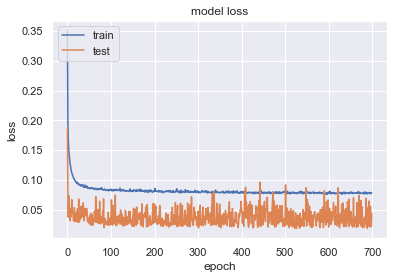

In [215]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [216]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

In [217]:
seq2seq_raw_values = df.values
seq2seq_raw_values = seq2seq_raw_values[:].reshape(len(seq2seq_raw_values),features)
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
test =  supervised_values[-245*1:]

print('test',test.shape)

test (245, 1554)


In [218]:
test_input_seq , test_output_seq = test[: , :n_lag*features] , test[:,n_lag*features:]
test_output_seq = test_output_seq[: , ::features]
test_input_seq = test_input_seq.reshape((test_input_seq.shape[0],n_lag,features))
print('test_input_seq',test_input_seq.shape)
print('test_output_seq',test_output_seq.shape)


test_input_seq (245, 30, 42)
test_output_seq (245, 7)


In [219]:
b = []

forecasts = np.zeros((len(test_input_seq),n_seq))
for i in range(len(test_input_seq)):
    b = predict_sequence(test_input_seq[i:i+1,:,:])[0,:,0]
    for j in range(n_seq):
        forecasts[i,j] = b[j]

In [220]:
forecasts_BBBB=list()
for i in range(len(forecasts)):
    forecasts_BBBB.append(forecasts[i,:])
	
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	b = np.array([0.0])
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + b)
	return inverted
	
import numpy as np
forecast_pred = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = array(forecasts_BBBB[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	forecast_pred.append(inv_diff)

forecast_14steps = forecast_pred
actual = [row[:] for row in test_output_seq]
actual_value = list()
for i in range(len(actual)):
	# create array from forecast
	forecast = array(actual[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	actual_value.append(inv_diff)
 

In [227]:
day = n_seq
actual_np = np.zeros(len(forecast_14steps))
print(actual_np.shape)
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            if (i/day)< (len(forecast_14steps)/day) :
                actual_np[j+i] = actual_value[i+day-1][j]
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                actual_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = actual_value[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]


        
        for j in range(len(test)%day):
            actual_np[i+j] = actual_value[-1][j-(len(test)%day)]
        
            
#print(actual_np)

(245,)


In [228]:
pred_np = np.zeros(len(forecast_14steps))
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            if (i/day)< (len(forecast_14steps)/day) :
                pred_np[j+i] = forecast_14steps[i+day-1][j]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                pred_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = forecast_14steps[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        for j in range(len(test)%day):
            pred_np[i+j] = forecast_14steps[-1][j-(len(test)%day)]

In [229]:
np.corrcoef(actual_np,pred_np)

array([[1.        , 0.76456147],
       [0.76456147, 1.        ]])

In [224]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(actual_np, pred_np))
print('RMSE: %.3f' % rmse)

RMSE: 1.450


# Trading

In [225]:
Go_UP = 1
Go_Down = 1
fee_buy = 0.00145
fee_sell = 0.00445
cash =10000
stock_num = 0
action_count = 0 
Return = 0
action_signal  = np.zeros(len(test))
for i in range(0,len(actual_np),n_seq):
    max_stock_price=pred_np[i]
    min_stock_price=pred_np[i]
    for j in range(n_seq):
        #print('i',i,(pred_np[i+j+1] - pred_np[i])/pred_np[i]*100)
        #print(pred_np[i+j],'i=',i)
        #print(i,j)
        if (i+j+1)<len(actual_np):
            if pred_np[i+j+1] > max_stock_price:
                max_stock_price=pred_np[i+j+1]
            elif pred_np[i+j+1]< min_stock_price:
                min_stock_price=pred_np[i+j+1]
            #print('i=',i,pred_np[i+j+1],'max=',max_stock_price,'min=',min_stock_price)
    
    #print('max=',(max_stock_price-pred_np[i])/pred_np[i]*100 ,'min=',(min_stock_price-pred_np[i])/pred_np[i]*100 )
    
    
    if (max_stock_price-pred_np[i])/pred_np[i]*100 > 1 and abs(max_stock_price-pred_np[i]) > abs(min_stock_price-pred_np[i]):
        if cash > actual_np[i]+20:
            a = int(cash/actual_np[i])
            cash = cash-(actual_np[i]*a)-(actual_np[i]*a)*fee_buy
            while cash < 0:
                cash+=actual_np[i]
                a=a-1
            stock_num = a
            action_count+=1
            action_signal[i] = 1
            #print('Buy','stock_num=',stock_num,'cash=',cash,'current_stock=',actual_np[i])
    elif (min_stock_price-pred_np[i])/pred_np[i]*100 < -1 and abs(min_stock_price-pred_np[i]) > abs(max_stock_price-pred_np[i]):
        if stock_num > 0 :
            cash += stock_num*actual_np[i]-stock_num*actual_np[i]*fee_sell
            stock_num = 0
            action_count+=1
            action_signal[i] = 2
            #print('Sell','stock_num=',stock_num,'cash=',cash,'current_stock=',actual_np[i])
            
        
Return = ((cash + stock_num*actual_np[-1])-10000)/10000*100
print('return=',Return,'action=',action_count,'cash=',cash,'stock_num=',stock_num)


return= 1.8311431462635117 action= 15 cash= 4.1137946263512895 stock_num= 260


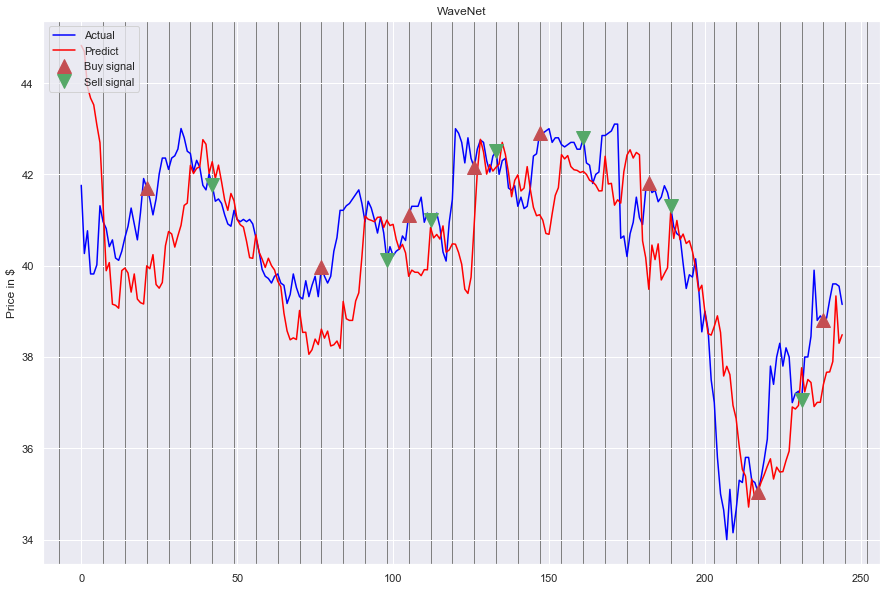

In [230]:
plt.rcParams.update({'font.size': 18})

# Initialize the `signals` DataFrame with the `signal` column
#prices_show = series.values
prices_show = df['close'].values[-245:]
prices_show = pd.Series(prices_show)
prices_show = prices_show.reset_index(drop = True)
signals_a = pd.DataFrame(index=prices_show.index)
signals_a['signal'] = 0.0
signals_a['value'] = 0.0
# Create signals
#print('action_np',action_np,'prices_show',prices_show.shape)
signals_a['signal']=action_signal
signals_a['value'] = prices_show

#print(signals_a)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# Initialize the plot figure
fig = plt.figure(figsize=(15,10))
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,
ylabel='Price in $')
plt.title('WaveNet')
spacing = n_seq # This can be your user specified spacing.
minorLocator = MultipleLocator(spacing)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.grid(which = 'minor',color='grey')
# Plot the closing price
#prices_show.plot(ax=ax1, color='b', label='Actual')
x_axis = np.arange(len(prices_show))
plt.plot(x_axis,prices_show,color='blue', label='Actual')
plt.plot(x_axis,pred_np,color='red', label='Predict')

plt.legend(loc='upper left')

# Plot the buy signals
ax1.plot(signals_a.loc[signals_a.signal == 1.0].index,signals_a.value[signals_a.signal == 1.0],'^',label='Buy signal', markersize=14, color='r')
ax1.plot(signals_a.loc[signals_a.signal == 2.0].index,signals_a.value[signals_a.signal == 2.0],'v',label='Sell signal', markersize=14, color='g') 
ax1.legend(loc='upper left');

plt.show()